### Product applications
#### We found how satisifed are U.S people with different hospital services.
#### Rating for past three years?
#### How change of ownerships affected the hospital rating?
#### Did emergency services play key role in increasing the rating?

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

In [2]:
host = 'slucor2022-instance-1.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2022'
password = 'SLUcor2022'
database = 'hds5210'

### Connecting to MySQL server and creating a table on my name

In [3]:
conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + '/' + 
                     database, echo=False)

import getpass
myname = getpass.getuser().split('-')[1]
myname
MYTABLE = myname + '_final'

conn.connect()

### Loading all the necessary data.
#### Data Formats: Excel, CSV, JSON
#### Data Sources: Local files, MySQL DB. 

In [4]:
cms_2020 = pd.read_csv("cms_hospital_patient_satisfaction_2020.csv")
cms_2019 = pd.read_json("cms_hospital_patient_satisfaction_2019.json")
cms_2018 = pd.read_csv("cms_hospital_patient_satisfaction_2018.csv")
cms_2018.to_sql(MYTABLE, conn, if_exists = 'replace', index = False)
cms_2018_sql = pd.read_sql_query('SELECT * FROM ' + MYTABLE, conn)

/opt/tljh/user/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,14,17,19,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### merge_data accepts three data files or data frames and merges them returns the merged data frame. 

In [5]:
def merge_data(file1, file2, file3):
    import pandas as pd
    data = []
    data.append(file1)
    data.append(file2)
    data.append(file3)
    return pd.concat(data)

In [6]:
data = merge_data(cms_2020, cms_2019, cms_2018_sql)

### fill_all_na takes any dataframe as input and returns the dataframe by replacing the NaN values by mean of the respective column. We need to make sure that we are giving numeric columns.

In [7]:
def fill_all_na(df):
    for column in df.columns:
        if any(df[column].isna()):
            df[column].fillna(df[column].mean(), inplace = True)
    return df

### The below function is useful for us to clean the data, and make those columns numeric. Made this functions as couple of columns can use this to clean(as they have similar type of non-numeric values.)

In [8]:
def preprocess_pat_sur_rating(data, column):
    cms_rating = data[data[column] != 'Not Applicable']
    cms_rating = cms_rating[cms_rating[column] != 'Not Available']
    cms_rating[column] = cms_rating[column].astype('int')
    return cms_rating

### Pivoting the rating datatable with below parameters, which helps us in understanding all individual ratings for every facility ID. 

In [9]:
cms_rating = preprocess_pat_sur_rating(data, 'Patient Survey Star Rating')
cms_rating_pivot = cms_rating.pivot_table(index = 'Facility ID', values = 'Patient Survey Star Rating',columns = "HCAHPS Question").reset_index()

In [10]:
fill_all_na(cms_rating_pivot)
cms_rating_pivot

HCAHPS Question,Facility ID,Care transition - star rating,Cleanliness - star rating,Communication about medicines - star rating,Discharge information - star rating,Doctor communication - star rating,Nurse communication - star rating,Overall hospital rating - star rating,Quietness - star rating,Recommend hospital - star rating,Staff responsiveness - star rating,Summary star rating
0,10001,2.0000,2.500000,2.0,3.000000,2.5,2.0,2.500000,4.000000,3.000000,1.5,2.000000
1,10005,3.0000,2.500000,4.0,3.500000,4.0,3.5,3.000000,3.500000,3.000000,3.0,3.000000
2,10006,2.5000,1.000000,2.5,2.500000,3.0,2.5,2.000000,3.000000,2.000000,2.0,2.500000
3,10007,2.0000,2.500000,3.0,3.000000,4.5,2.5,3.000000,3.500000,3.000000,3.0,3.000000
4,10011,3.0000,2.000000,2.5,3.000000,3.0,2.5,3.000000,3.000000,3.000000,3.0,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6018,520091,3.0000,3.000000,4.0,3.000000,3.0,4.0,3.000000,2.000000,4.000000,4.0,3.000000
6019,520095,5.0000,5.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.0,5.000000
6020,520096,2.0000,2.000000,3.0,3.000000,3.0,3.0,3.000000,2.000000,2.000000,3.0,3.000000
6021,520097,3.0000,4.000000,3.0,3.000000,4.0,4.0,4.000000,3.000000,3.000000,3.0,3.000000


### Now, as we have three different years data, we can pivot them using Year as a column parameter, which would help us in finding out the increase in the overall hospital rating per every year

In [11]:
any(data['Hospital overall rating'].isna())

True

In [12]:
data['Hospital overall rating'].fillna('0',inplace = True)

In [13]:
cms_overall_rating = preprocess_pat_sur_rating(data, 'Hospital overall rating')
cms_overall_rating_pivot = cms_overall_rating.pivot_table(index = 'Facility ID', values = 'Hospital overall rating', columns = 'Year')
cms_overall_rating_pivot.reset_index()

Year,Facility ID,2018,2019,2020
0,10001,3.0,2.0,NaN
1,10005,2.0,1.0,NaN
2,10006,2.0,3.0,NaN
3,10007,2.0,1.0,NaN
4,10008,4.0,4.0,NaN
...,...,...,...,...
6416,520091,NaN,NaN,4.0
6417,520095,NaN,NaN,5.0
6418,520096,NaN,NaN,1.0
6419,520097,NaN,NaN,4.0


In [14]:
any(data['Hospital overall rating'].isna())

False

In [15]:
fill_all_na(cms_overall_rating_pivot)
cms_overall_rating = cms_overall_rating_pivot.reset_index()

### pre_process_for_histogram takes in a data_frame and returns a separate dictionary for each of the year with the frequency of rating(1-5).

In [16]:
def pre_process_for_histogram(df):
    year_2018_dict = dict()
    year_2019_dict = dict()
    year_2020_dict = dict()
    
    for i in range(1, 6): 
        #initiating with 0 frequency for all three years
        year_2018_dict[i] = 0
        year_2019_dict[i] = 0
        year_2020_dict[i] = 0
    
    for ind in df.index: 
        for column in df.columns:
            #increase the frequency of that particular rating based on the year
            if column == 2018: 
                year_2018_dict[int(df[column][ind])] += 1
            if column == 2019:
                year_2019_dict[int(df[column][ind])] += 1
            if column == 2020:
                year_2020_dict[int(df[column][ind])] += 1
    return year_2018_dict, year_2019_dict, year_2020_dict 

### Just trying to escape the step of plotting the histogram every time we need. so created a plot_hist function which takes in list of all dictionaries and iterates through each and then plots a bar/hist graph.

In [17]:
def plot_hist(plot_data):
    import matplotlib.pyplot as plt
    for data in plot_data:
        plt.bar(data.keys(), data.values())
        plt.show()

In [18]:
year_2018, year_2019, year_2020 = pre_process_for_histogram(cms_overall_rating) 

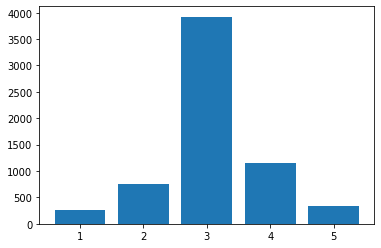

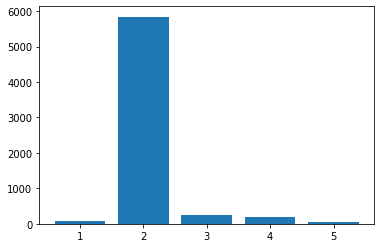

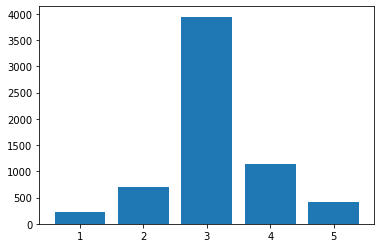

In [19]:
year_list = []
year_list.append(year_2018)
year_list.append(year_2019)
year_list.append(year_2020)
plot_hist(year_list)

In [20]:
year_list

[{1: 259, 2: 750, 3: 3924, 4: 1153, 5: 335},
 {1: 89, 2: 5841, 3: 262, 4: 178, 5: 51},
 {1: 225, 2: 702, 3: 3945, 4: 1141, 5: 408}]

### Wanted to understand how is the overall rating under each ownership. With this we can get to know which owner should be more concerned and dedicated to increase the rating. 

In [21]:
data = preprocess_pat_sur_rating(data, 'Hospital overall rating')
grouped_data_ownership = data.groupby(['Hospital Ownership'])['Hospital overall rating'].mean().reset_index()

In [22]:
grouped_data_ownership

,Hospital Ownership,Hospital overall rating
0,Government - Federal,2.430075
1,Government - Hospital District or Authority,3.044482
2,Government - Local,3.074421
3,Government - State,2.823382
4,Physician,3.663612
5,Proprietary,2.795225
6,Tribal,3.104384
7,Voluntary non-profit - Church,3.332902
8,Voluntary non-profit - Other,3.247963
9,Voluntary non-profit - Private,3.276074


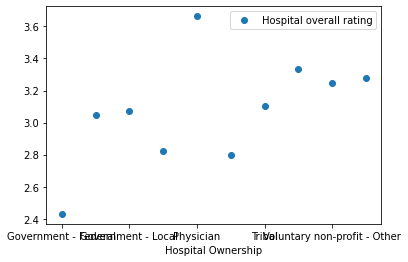

In [23]:
grouped_data_ownership.plot(x='Hospital Ownership', y='Hospital overall rating', style='o')

### Generally, if there are emergency services in a hospital, then there are high chances that the rating of the hospital is pretty better than average rating. But, this is a new finding... We could see that average rating with emergency services is lesser than without emergency services. Probably, this is because of many hospitals who have emergency services options are not executing them well.   

#### Reading the emergency data, rating from different files and joining them on facilityID column.

In [24]:
facility_id_emergency = pd.read_excel("facility_id_emergency_services.xlsx")
facility_id_rating = pd.read_excel("facility_id_overall_rating.xlsx")

In [25]:
joined_on_facility_id = facility_id_emergency.merge(facility_id_rating, how='inner')

#### Now, we calculate the average of overall rating after group on FacilityID and Emergency Services columns.

In [26]:
grouped_facility_id = joined_on_facility_id.groupby(['Facility ID', 'Emergency Services'])['Hospital overall rating'].mean().reset_index()

#### Utilizing the plot_hist function written above and plotting the graph to show the average rating w.r.t hospitals having emergency services and not having them.

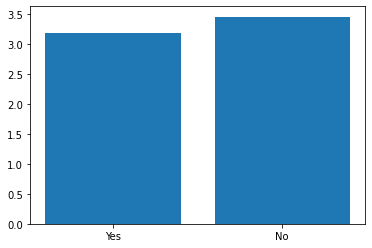

In [27]:
emergency_rating = dict()
emergency_rating['Yes'] = grouped_facility_id[grouped_facility_id["Emergency Services"] == 'Yes']['Hospital overall rating'].mean()
emergency_rating['No'] = grouped_facility_id[grouped_facility_id["Emergency Services"] == 'No']['Hospital overall rating'].mean()
plot_hist([emergency_rating])

In [ ]:
a=input('''
Are you ready to submit your work?
1. Click the Save icon (or do Ctrl-S / Cmd-S)
2. Type "yes" or "no" below
3. Press Enter

''')

if a=='yes':
    !git add Sahaja_final.ipynb
    !git commit -a -m "Submitting Sahaja_s"
    !git push
else:
    print('''
    
OK. We can wait.
''')